# Driver Identification using ResNet50 and GRU (RNN)
To better understand the code, check out `./prep_files/ResNet50_GRU_driverID.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

Also the dataset used was different as that stored all data in memory while we plan on streaming from local storage as the dataset is 40+Gb

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import random_split, DataLoader

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDatasetImproved, FeatureMapDatasetNORoT

compute class weights

In [3]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

del y_train

### 1. First run with desirable config

In [3]:
base_dir = './data/feature_maps_labels/'
np.random.seed(42)

train_datasets = FeatureMapDatasetNORoT(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetNORoT(base_dir, mode='valid', rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [4]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
optimizer = optim.Adam(model.parameters(), lr=0.00132603, weight_decay=0.00111036)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.304855)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [5]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [6]:
firstRun_hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path='./model_checkpoint/run1_driver1D_ResNet50GRU_chkpt.pth')

np.save('./model_checkpoint/run1_driver1D_ResNet50GRU_history.npy', np.array(firstRun_hist))

   Epoch [1/30], Train Loss: 1.2816, Train Accuracy: 61.09%, Val Loss: 1.1974, Val Accuracy: 69.44%
   Epoch [2/30], Train Loss: 1.1753, Train Accuracy: 69.45%, Val Loss: 1.1490, Val Accuracy: 64.56%
   Epoch [3/30], Train Loss: 1.1169, Train Accuracy: 70.55%, Val Loss: 1.1117, Val Accuracy: 73.50%
   Epoch [4/30], Train Loss: 1.0483, Train Accuracy: 71.51%, Val Loss: 1.0377, Val Accuracy: 71.76%
   Epoch [5/30], Train Loss: 0.9830, Train Accuracy: 72.87%, Val Loss: 1.0247, Val Accuracy: 72.38%
   Epoch [6/30], Train Loss: 0.9594, Train Accuracy: 73.90%, Val Loss: 1.0173, Val Accuracy: 72.93%
   Epoch [7/30], Train Loss: 0.9457, Train Accuracy: 73.62%, Val Loss: 1.0155, Val Accuracy: 72.45%
   Epoch [8/30], Train Loss: 0.9406, Train Accuracy: 74.15%, Val Loss: 1.0586, Val Accuracy: 73.64%
   Epoch [9/30], Train Loss: 0.9515, Train Accuracy: 73.71%, Val Loss: 1.0197, Val Accuracy: 71.90%
   Epoch [10/30], Train Loss: 0.9391, Train Accuracy: 73.73%, Val Loss: 1.0168, Val Accuracy: 72.54%

In [8]:
from src.plot import plot_history

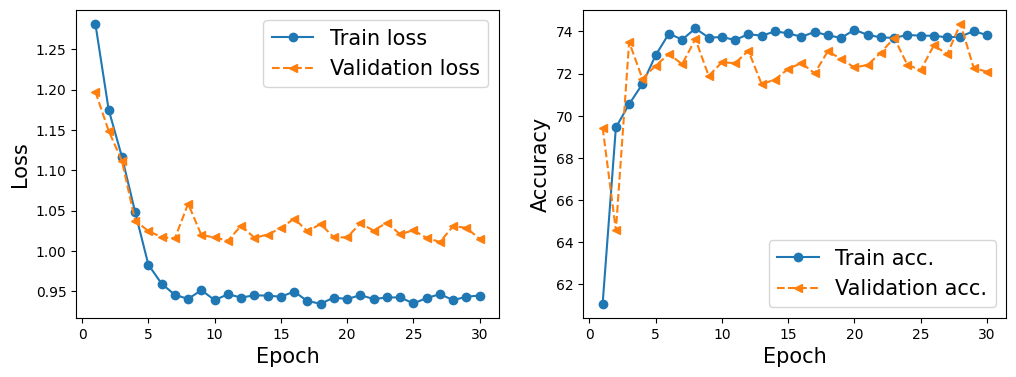

In [8]:
plot_history(firstRun_hist)

### 2. Second run with desirable config: 
Learning rate decay is too fast, let's see if an increase in `gamma` would help

In [4]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
optimizer = optim.Adam(model.parameters(), lr=0.00132603, weight_decay=0.00111036)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [5]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [6]:
secondRun_hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path='./model_checkpoint/run2_driver1D_ResNet50GRU_chkpt.pth')

np.save('./model_checkpoint/run2_driver1D_ResNet50GRU_history.npy', np.array(secondRun_hist))

   Epoch [1/30], Train Loss: 1.2928, Train Accuracy: 63.03%, Val Loss: 1.2134, Val Accuracy: 71.46%
   Epoch [2/30], Train Loss: 1.2128, Train Accuracy: 68.67%, Val Loss: 1.2101, Val Accuracy: 69.16%
   Epoch [3/30], Train Loss: 1.2299, Train Accuracy: 66.88%, Val Loss: 1.4624, Val Accuracy: 76.84%
   Epoch [4/30], Train Loss: 1.2707, Train Accuracy: 66.13%, Val Loss: 1.2442, Val Accuracy: 70.79%
   Epoch [5/30], Train Loss: 1.2044, Train Accuracy: 68.88%, Val Loss: 1.1005, Val Accuracy: 76.88%
   Epoch [6/30], Train Loss: 1.0783, Train Accuracy: 71.84%, Val Loss: 1.0730, Val Accuracy: 72.81%
   Epoch [7/30], Train Loss: 1.0456, Train Accuracy: 71.68%, Val Loss: 1.0344, Val Accuracy: 73.50%
   Epoch [8/30], Train Loss: 1.0128, Train Accuracy: 72.25%, Val Loss: 1.0334, Val Accuracy: 70.58%
   Epoch [9/30], Train Loss: 0.9855, Train Accuracy: 72.10%, Val Loss: 1.0155, Val Accuracy: 72.90%
   Epoch [10/30], Train Loss: 0.9517, Train Accuracy: 72.59%, Val Loss: 1.0406, Val Accuracy: 74.09%

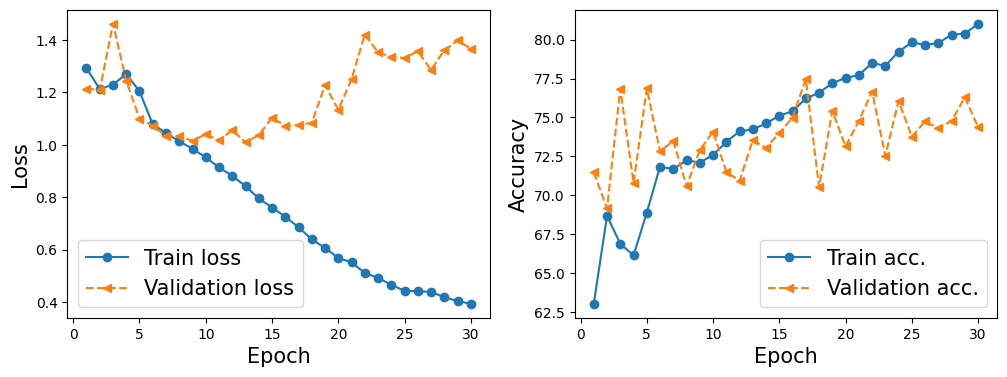

In [9]:
plot_history(secondRun_hist)

___

### 3. Third run with desirable config: 
This time I'm using the dataset class with the same augmentation as I used for the MTL model to allow for a fair comparison.

In [4]:
base_dir = './data/feature_maps_labels/'
np.random.seed(42)

train_datasets = FeatureMapDatasetImproved(base_dir, mode='train', rescale=False, augment=True)
val_test_datasets = FeatureMapDatasetImproved(base_dir, mode='valid', rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 32
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [5]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
optimizer = optim.Adam(model.parameters(), lr=0.00132603, weight_decay=0.00111036)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.304855)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [6]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [7]:
thirdRun_hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path='./model_checkpoint/run3_driver1D_ResNet50GRU_chkpt.pth')

np.save('./model_checkpoint/run3_driver1D_ResNet50GRU_history.npy', np.array(thirdRun_hist))

   Epoch [1/30], Train Loss: 1.3573, Train Accuracy: 53.04%, Val Loss: 1.2883, Val Accuracy: 57.16%
   Epoch [2/30], Train Loss: 1.2261, Train Accuracy: 66.78%, Val Loss: 1.1799, Val Accuracy: 69.58%


KeyboardInterrupt: 

In [ ]:
from src.plot import plot_history

In [ ]:
plot_history(thirdRun_hist)